# This notebook contains examples for the various geometric operations you can perform on the track data. 

# This may be useful for processing your raw data into a cleaner, more regular, more manageable format.

In [7]:
import trackio as tio
import glob
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import rasterio as rio
import geopandas as gp
from rasterio.plot import show

In [8]:
#define raw data files
data_path = './files'
files = glob.glob(f'{data_path}/*clipped_to_polygon*.csv')

#create the Dataset
ds = tio.read(raw_files=files,
              data_path='example00')


No dataset.db found in c:\code\trackio\notebooks\example00. 
Using default units/crs. 
Edit self.meta and then run self.refresh_meta to update.



In [9]:
#split the raw point data by agents
ds = ds.group_points(groupby='MMSI',
                     col_mapper=tio.mappers.columns,                        
                     meta_cols=['MMSI'],
                     data_cols=['Time',
                                'X',
                                'Y',
                                'Coursing',
                                'Speed'],
                     prefix='Vessel_',
                     ncores=4)

#split using spatiotemporal thresholds
ds = ds.split_tracks_spatiotemporal(time=3600*24, #time in seconds
                                    distance=0.5, #distance in CRS units (degrees here)
                                    ncores=4)

#refresh the metadata
ds = ds.refresh_meta(ncores=4)

ds

Refreshing metadata: 100%|██████████| 163/163 [00:05<00:00, 28.88it/s] 


New meta/databases saved to c:\code\trackio\notebooks\example00


Type:
    <class 'trackio.Dataset.Dataset'>
Status:
    0 Unprocessed CSV Files
    0 Processed CSV Files
    0 Unsplit Agent Files
    163 Split Agent Files
Static Data Fields:
    ['Agent ID', 'MMSI']
Dynamic Data Fields:
    ['Coursing', 'Speed', 'Time', 'X', 'Y']
Metadata:
    X: degrees
    Y: degrees
    CRS: EPSG:4326
Data Path:
    c:\code\trackio\notebooks\example00

# Reprojecting CRS

In [10]:
#get original track
original = ds.get_track(ds.tracks.index[10])

#reproject to another CRS
ds = ds.reproject_crs(3857, ncores=4)

#get reprojected track
reprojected = ds.get_track(ds.tracks.index[10])

Reprojecting CRS: 100%|██████████| 163/163 [00:06<00:00, 25.30it/s]


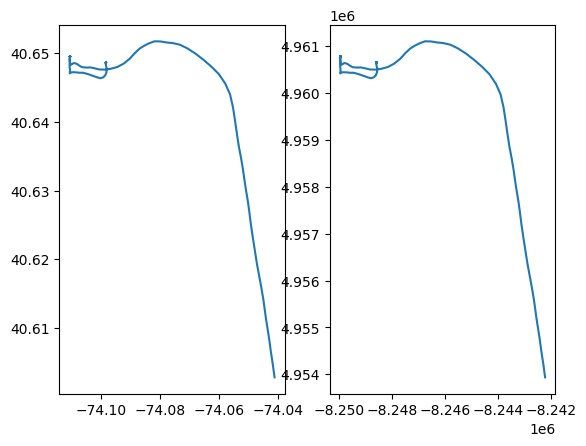

In [11]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'])
ax[1].plot(reprojected['X'], reprojected['Y'])

# Note that the `Dataset.meta` attribute updated the CRS and X,Y units. You'll need to run `Dataset.refresh_meta()` to make this permanent.

In [12]:
ds

Type:
    <class 'trackio.Dataset.Dataset'>
Status:
    0 Unprocessed CSV Files
    0 Processed CSV Files
    0 Unsplit Agent Files
    163 Split Agent Files
Static Data Fields:
    ['Agent ID', 'MMSI']
Dynamic Data Fields:
    ['Coursing', 'Speed', 'Time', 'X', 'Y']
Metadata:
    X: metre
    Y: metre
    CRS: EPSG:3857
Data Path:
    c:\code\trackio\notebooks\example00

# Spatial Resampling

In [13]:
#get original track
original = ds.get_track(ds.tracks.index[46])

#resample spacing
ds = ds.resample_spacing(100,
                         tracks=[ds.tracks.index[46]],
                         ncores=4)

#get resampled track
resampled = ds.get_track(ds.tracks.index[46])

Resampling track spacing: 100%|██████████| 1/1 [00:00<00:00, 250.06it/s]


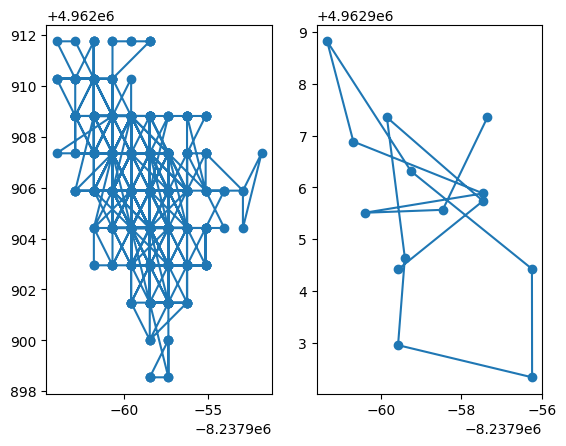

In [14]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'], '-o')
ax[1].plot(resampled['X'], resampled['Y'], '-o')

# Temporal Resampling

In [15]:
#define a track id
track_id = ds.tracks.index[9]

#get original track
original = ds.get_track(track_id)

#check existing temporal resolution
ds.tracks.loc[track_id].filter(like='Temporal')

Min Temporal Resolution             17
Mean Temporal Resolution    245.367925
Max Temporal Resolution          33449
Name: Vessel_368139870_T0, dtype: object

In [16]:
#temporal resample
ds = ds.resample_time(300, 
                      tracks=[track_id])

#get resampled track
resampled = ds.get_track(track_id)

Resampling track timing: 100%|██████████| 1/1 [00:00<00:00, 125.00it/s]


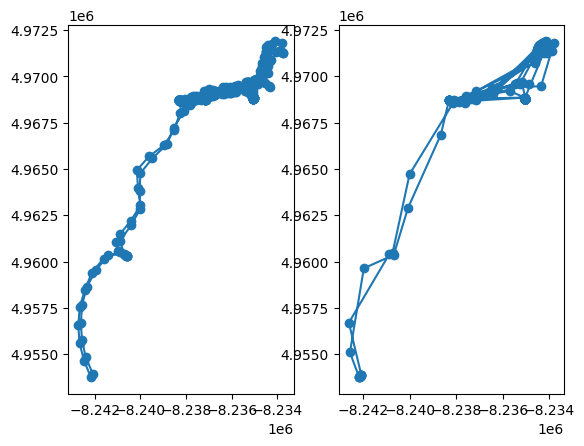

In [17]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'], '-o')
ax[1].plot(resampled['X'], resampled['Y'], '-o')

# Global Temporal Resampling

## You can also do a temporal resample to a global time axis. To do this, the time axis must span the times in the entire `Dataset`.

In [18]:
#get time span
tmin = ds.agents['Start Time'].min()
tmax = ds.agents['End Time'].max()

tmin, tmax

(Timestamp('2021-01-01 00:17:12'), Timestamp('2021-01-01 23:59:59'))

In [19]:
#make a new global time axis, 1min intervals
time = pd.date_range('2021-01-01', '2021-01-02', freq='60s')

In [20]:
#temporal resample
ds = ds.resample_time_global(time, 
                             ncores=4)

#refresh meta
ds = ds.refresh_meta(ncores=4)

Refreshing metadata: 100%|██████████| 163/163 [00:05<00:00, 27.50it/s] 


New meta/databases saved to c:\code\trackio\notebooks\example00


# Notice the time axis has been interpolated for all tracks now.

In [21]:
ds.tracks.filter(like='Time').head(5)

,Start Time,End Time
Track ID,,
Vessel_367725870_T0,2021-01-01 21:35:00,2021-01-01 22:08:00
Vessel_366896390_T0,2021-01-01 00:18:00,2021-01-01 23:59:00
Vessel_367605850_T0,2021-01-01 02:29:00,2021-01-01 20:33:00
Vessel_367758160_T0,2021-01-01 00:20:00,2021-01-01 23:55:00
Vessel_367661340_T0,2021-01-01 00:18:00,2021-01-01 05:31:00


In [22]:
ds.get_track(track_id)['Time'].head(5)

0   2021-01-01 00:33:00
1   2021-01-01 00:34:00
2   2021-01-01 00:35:00
3   2021-01-01 00:36:00
4   2021-01-01 00:37:00
Name: Time, dtype: datetime64[ns]

# Smoothing Sharp Corners

In [23]:
#define track id
track_id = ds.tracks.index[27]

#get original track
original = ds.get_track(track_id)

#smooth the tracks - for jagged corners
ds = ds.smooth_corners(tracks=[track_id],
                       refinements=2)

#get reprojected track
smooth = ds.get_track(track_id)

Smoothing sharp corners: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s]


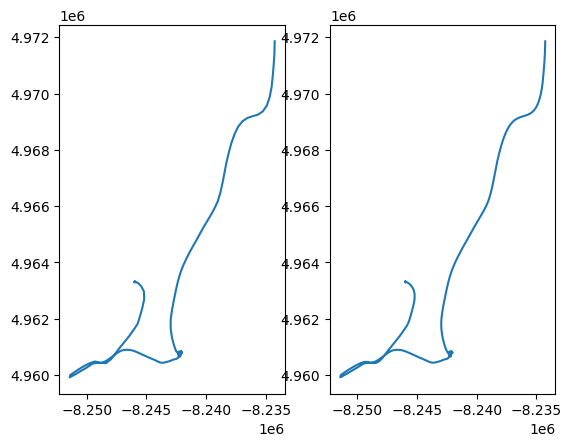

In [24]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'])
ax[1].plot(smooth['X'], smooth['Y'])

# Imprinting Geometry into Tracks

In [25]:
#define track id
track_id = ds.tracks.index[16]

#get original track
original = ds.get_track(track_id)

#get random point on track
pt = original.iloc[int(len(original)/2)]

#make a circle at this point
geometry = Point(pt[['X','Y']]).buffer(500)

#imprint the track with this geometry
ds = ds.imprint_geometry(geometry, tracks=[track_id])

#get imprinted
imprinted = ds.get_track(track_id)


Imprinting geometry into tracks: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


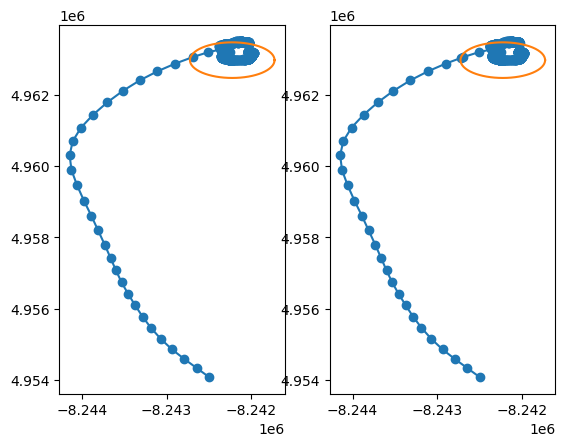

In [26]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'], '-o')
ax[0].plot(*geometry.exterior.xy)
ax[1].plot(imprinted['X'], imprinted['Y'], '-o')
ax[1].plot(*geometry.exterior.xy)

# Routing tracks through rasters


In [27]:
#define track ids
tracks_to_route = gp.read_file('files/route_tracks.gpkg')
track_ids = tracks_to_route['Track ID'].values

#original tracks
original = ds.to_gdf(tracks=track_ids)

Converting tracks to GeoDataFrame: 100%|██████████| 38/38 [00:00<00:00, 51.07it/s]


In [28]:
#read the raster
raster = rio.open('files/obstacle_raster.tif')

In [29]:
#route the track through the raster
ds = ds.route_through_raster(raster, 
                             tracks=track_ids, 
                             ncores=4,
                             fully_connected=True)

#get routed tracks
routed = ds.to_gdf(tracks=track_ids)

Converting tracks to GeoDataFrame: 100%|██████████| 38/38 [00:00<00:00, 42.99it/s]


<Axes: >

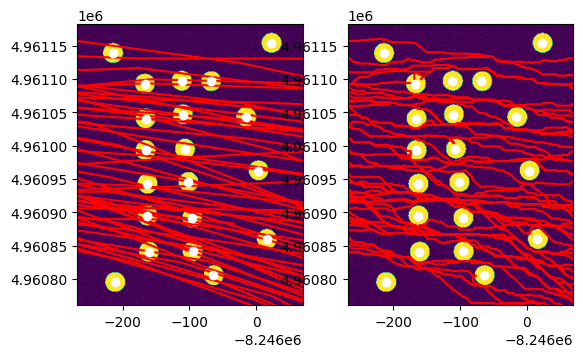

In [30]:
#read obstacle file
obstacles = gp.read_file('files/obstacles.gpkg')

#plot the two
fig, ax = plt.subplots(1,2)

#original
original.plot(ax=ax[0], color='r')
obstacles.plot(ax=ax[0], color='w', zorder=10)
show(raster, ax=ax[0])

#routed
routed.plot(ax=ax[1], color='r')
obstacles.plot(ax=ax[1], color='w', zorder=10)
show(raster, ax=ax[1])
